<a href="https://colab.research.google.com/github/Kim-JH-01/AI_lab_Juhun/blob/main/week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
from google.colab import files

print("--- 1. 데이터셋 zip 파일 업로드 ---")
print("파일을 업로드하세요.")

# 파일 업로드 창 띄우기
uploaded = files.upload()

# 업로드된 zip 파일 이름 가져오기
zip_name = list(uploaded.keys())[0]

# 압축 풀기
print(f"\n'{zip_name}' 파일의 압축을 해제합니다...")
!unzip -q "{zip_name}"

# zip 파일 내부의 최상위 폴더 이름으로 data_dir 설정
# 예: zip_name이 'cat_dog_data.zip'이면 data_dir은 'cat_dog_data'가 됩니다.
data_dir = os.path.splitext(zip_name)[0]
print(f"✅ 압축 해제 완료. 데이터 디렉터리: '{data_dir}'")

--- 1. 데이터셋 zip 파일 업로드 ---
파일을 업로드하세요.


Saving sample_computer_vision.zip to sample_computer_vision.zip

'sample_computer_vision.zip' 파일의 압축을 해제합니다...
✅ 압축 해제 완료. 데이터 디렉터리: 'sample_computer_vision'


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()  # 대화형 모드 켜기

# --- 2. 데이터 변환 및 로드 ---

# 학습을 위한 데이터 증강 및 정규화
# 검증을 위한 정규화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 1단계에서 설정된 data_dir을 사용
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# GPU 또는 CPU 장치 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print(f"클래스: {class_names}")

Using cuda device
클래스: ['cats', 'dogs']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- [결과물 1] 데이터셋 시각화 ---


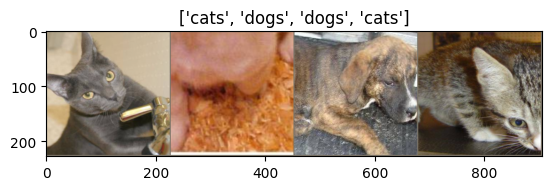

In [5]:
def imshow(inp, title=None):
    """Tensor를 이미지로 보여주기 위한 함수"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신을 위해 잠시 멈춤

print("\n--- [결과물 1] 데이터셋 시각화 ---")
# 학습 데이터 배치 가져오기
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 그리드(grid) 만들기
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # 학습 체크포인트를 저장할 임시 디렉터리 생성
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # 각 에폭은 학습 단계와 검증 단계를 가짐
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # 모델을 학습 모드로 설정
                else:
                    model.eval()   # 모델을 평가 모드로 설정

                running_loss = 0.0
                running_corrects = 0

                # 데이터 반복
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # 파라미터 경사도를 0으로 설정
                    optimizer.zero_grad()

                    # 순전파
                    # 학습 시에만 연산 기록을 추적
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # 학습 단계인 경우 역전파 + 최적화
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # 통계
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # 모델을 깊은 복사(deep copy)
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # 가장 나은 모델 가중치 로드
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
print("\n--- [결과물 2a] Finetuning 모델 학습 시작 ---")

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# '개'와 '고양이' 2개의 클래스로 출력 레이어를 변경
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 파라미터를 최적화
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 모델 학습
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


--- [결과물 2a] Finetuning 모델 학습 시작 ---
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


Epoch 0/24
----------
train Loss: 0.5955 Acc: 0.7415
val Loss: 0.2859 Acc: 0.8850

Epoch 1/24
----------
train Loss: 0.6390 Acc: 0.7625
val Loss: 0.3406 Acc: 0.8600

Epoch 2/24
----------
train Loss: 0.4620 Acc: 0.8084
val Loss: 0.1817 Acc: 0.9400

Epoch 3/24
----------
train Loss: 0.4196 Acc: 0.8313
val Loss: 0.1317 Acc: 0.9500

Epoch 4/24
----------
train Loss: 0.4670 Acc: 0.8204
val Loss: 0.1486 Acc: 0.9550

Epoch 5/24
----------
train Loss: 0.4771 Acc: 0.8194
val Loss: 0.1284 Acc: 0.9550

Epoch 6/24
----------
train Loss: 0.4587 Acc: 0.8263
val Loss: 0.1167 Acc: 0.9650

Epoch 7/24
----------
train Loss: 0.3340 Acc: 0.8523
val Loss: 0.0977 Acc: 0.9850

Epoch 8/24
----------
train Loss: 0.3372 Acc: 0.8483
val Loss: 0.1253 Acc: 0.9500

Epoch 9/24
----------
train Loss: 0.3010 Acc: 0.8693
val Loss: 0.0901 Acc: 0.9800

Epoch 10/24
----------
train Loss: 0.2671 Acc: 0.8762
val Loss: 0.1149 Acc: 0.9600

Epoch 11/24
----------
train Loss: 0.2860 Acc: 0.8723
val Loss: 0.0890 Acc: 0.9800

Ep

In [9]:
print("\n--- [결과물 2b] Fixed Feature Extractor 모델 학습 시작 ---")

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
# 경사도가 흐르지 않도록 모든 파라미터를 동결(freeze)
for param in model_conv.parameters():
    param.requires_grad = False

# 마지막 레이어는 새로 생성되므로 기본적으로 requires_grad=True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과 다르게, 마지막 레이어의 파라미터만 최적화
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# 모델 학습
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)


--- [결과물 2b] Fixed Feature Extractor 모델 학습 시작 ---
Epoch 0/24
----------
train Loss: 0.5306 Acc: 0.7625
val Loss: 0.1207 Acc: 0.9650

Epoch 1/24
----------
train Loss: 0.5211 Acc: 0.7904
val Loss: 0.2313 Acc: 0.9300

Epoch 2/24
----------
train Loss: 0.5781 Acc: 0.7745
val Loss: 0.1153 Acc: 0.9600

Epoch 3/24
----------
train Loss: 0.4689 Acc: 0.8194
val Loss: 0.2227 Acc: 0.9200

Epoch 4/24
----------
train Loss: 0.4908 Acc: 0.7944
val Loss: 0.1014 Acc: 0.9700

Epoch 5/24
----------
train Loss: 0.5060 Acc: 0.8094
val Loss: 0.1367 Acc: 0.9650

Epoch 6/24
----------
train Loss: 0.5053 Acc: 0.8124
val Loss: 0.5905 Acc: 0.7400

Epoch 7/24
----------
train Loss: 0.4019 Acc: 0.8433
val Loss: 0.1201 Acc: 0.9650

Epoch 8/24
----------
train Loss: 0.3466 Acc: 0.8413
val Loss: 0.1049 Acc: 0.9750

Epoch 9/24
----------
train Loss: 0.3853 Acc: 0.8323
val Loss: 0.1272 Acc: 0.9600

Epoch 10/24
----------
train Loss: 0.3107 Acc: 0.8703
val Loss: 0.1114 Acc: 0.9650

Epoch 11/24
----------
train Loss: 


--- [결과물 3] 예측 결과 시각화 (6개 이미지) ---


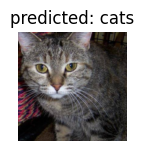

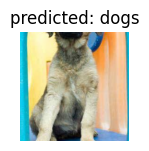

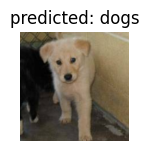

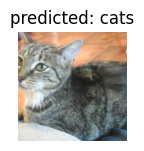

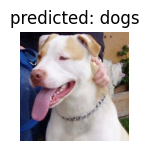

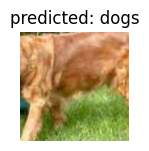

In [10]:
print("\n--- [결과물 3] 예측 결과 시각화 (6개 이미지) ---")
plt.ioff() # 대화형 모드 끄기
visualize_model(model_conv)
plt.show()